#### Problem Lab 0: Fun Regression Model

Generating some fake and fun data to predict cup cakes consumption in these awry times...

<table>
  <tr><td>
    <img src="https://miro.medium.com/max/593/1*pfmeGgGM5sxmLBQ5IQfQew.png"
         alt="Matrix" width="600">
    </td>
  <tr><td></td></tr>
  <tr><td>Seems like a sweet consumption problem to have ...</td></tr>
  <tr><td>
    <img src="https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcSfq0lfEMNHr8h65oFR_fFPR_PsukQL60FiKDU16VB7Li17q5Fd&usqp=CAU" 
         alt="Cup Cakes" width="600">
  </td></tr>
</table>

## Import Modules

In [0]:
%pip install --upgrade typing_extensions mlflow

import os
import shutil
import pprint
import tempfile
from random import random, randint
import numpy as np
import matplotlib.pyplot as plt
import mlflow.sklearn
import mlflow
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from mlflow.tracking import MlflowClient

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


### Random Text for the Message Artifacts

In [0]:
RANDOM_TEXTS = ["Look, Stay home for us, so we can order some cup cakes!",
                "This shelter-in-placeinduces sweet appetites. Look at the graphs of cupcakes consumption in SF and NYC!",
                "Don't Despair for those in-place shelters, for help and hope are on the way!",
                "Guess what, I'll just hack on this MLflow thingy. Seems way cool!",
                "Trying and learning the new MLflow Tracking component ... Perché No!",
                "Bonjour! Nice to be virtual now!"]

### Utility functions 

In [0]:
def get_temporary_directory_path(prefix, suffix):
  """
  Get a temporary directory and files for artifacts
  :param prefix: name of the file
  :param suffix: .csv, .txt, .png etc
  :return: object to tempfile.
  """

  temp = tempfile.NamedTemporaryFile(prefix=prefix, suffix=suffix)
  return temp

def gen_random_text():
    """
    Random text for messages
    :return: return string message text
    """
    return RANDOM_TEXTS[randint(0, 5)]


def gen_random_scatter_plots(npoints):
    """
    Random scatter plot geneator to save as an MLflow artifact in an MLflow experiment
    run
    :param npoints: number of data points for the scatter plot
    :return: return a tuple
    """
    data = {'a': np.arange(npoints),
            'c': np.random.randint(0, npoints, npoints),
            'd': np.random.randn(npoints)}
    data['b'] = data['a'] + 10 * np.random.randn(npoints)
    data['d'] = np.abs(data['d']) * 100

    plt.clf()
    fig, ax = plt.subplots()

    plt.scatter('a', 'b', c='c', s='d', data=data)
    plt.title("Cupcake Consumption")
    plt.xlabel('Vanilla,Chocolate,Carrot: NYC')
    plt.ylabel('Vanilla,Chocolate,Carrot: San Francisco')
    return (fig, ax)

## Fluent Python MLflow APIs

MLflow method to record create a model, log model, parameters, metrics, and artifacts for each run

In [0]:
def mlflow_run(params, run_name="MLflow Workshop Part-1"):
    """
    Function to start a run within a Default experiment
    :param params: parameters used for the run, such as arguments to RandomForestRegressor class scikit-learn
    :param run_name: label for the name of the run
    :return: experiment ID and run ID
    """

    with mlflow.start_run(run_name=run_name) as run:
        # Get the run and experimentid
        
        run_id = run.info.run_id
        experiment_id = run.info.experiment_id

        # Create our model type instance and some random fake regression data
        sk_learn_rfr = RandomForestRegressor(**params)
        # https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_regression.htm
        X, y = make_regression(n_features=20, n_samples=5000, random_state=42)
        # Train/Test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # typicaly here you would train and evaluation your model
        sk_learn_rfr.fit(X_train, y_train)
        y_pred =  sk_learn_rfr.predict(X_test)
        
        mae = metrics.mean_absolute_error(y_test, y_pred)
        mse = metrics.mean_squared_error(y_test, y_pred)
        rsme = np.sqrt(mse)

        # Log params and metrics using the MLflow APIs
        mlflow.log_params(params)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("mse", mse)
        mlflow.log_metric("rsme", rsme)

        # Set the notes for experiment and the Runs
        MlflowClient().set_experiment_tag(experiment_id,
                                          "mlflow.note.content",
                                          "This is a fake cup cake predicion experiment: Getting started with MLflow Workhop Series Part 1 ...")
        MlflowClient().set_tag(run_id,
                               "mlflow.note.content",
                               "This Run is for getting started as part of MLflow Workhop Series Part 1 ...")

        # Log the model
        mlflow.sklearn.log_model(
            sk_model=sk_learn_rfr,
            artifact_path="sklearn-model")

        # Create sample message artifact
        if not os.path.exists("messages"):
            os.makedirs("messages")
        with open("messages/message.txt", "w") as f:
            f.write(gen_random_text())

        mlflow.log_artifact("messages")
        shutil.rmtree('messages')

        # Create scatter random plot artifacts file and log them a artifacts
        for npoints in range(55, 70, 5):
            fig, ex = gen_random_scatter_plots(npoints)
            temp_file_name = get_temporary_directory_path("scatter-plot-", ".png")
            temp_name = temp_file_name.name
            try:
                fig.savefig(temp_name)
                mlflow.log_artifact(temp_name, "scatter_plots")
            finally:
                temp_file_name.close()  # Delete the temp file

        return (run_id, experiment_id)

### Driver to run experiment with three runs

Define parameters for three different runs

In [0]:
parameters = [ {"n_estimators": 3, "max_depth":2, "random_state": 42},
               {"n_estimators": 6, "max_depth":4, "random_state": 42},
               {"n_estimators": 12, "max_depth":6, "random_state": 42}]

2025/07/31 04:35:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
🔗 View Logged Model at: https://dbc-b2d30165-76df.cloud.databricks.com/ml/experiments/4230816160263147/models/m-f6183fb654f64e8cbd9689f9238f2342?o=4476931374519718
2025/07/31 04:35:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


run_id=12a5d20334a2414f9cbdaf52ce1f04aa
experiment_id=4230816160263147


2025/07/31 04:35:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
🔗 View Logged Model at: https://dbc-b2d30165-76df.cloud.databricks.com/ml/experiments/4230816160263147/models/m-7872cd8e919e43ca8a910c8c583b68f2?o=4476931374519718
2025/07/31 04:35:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


run_id=34f6716f3365446d985043b78c22ffa5
experiment_id=4230816160263147


2025/07/31 04:35:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
🔗 View Logged Model at: https://dbc-b2d30165-76df.cloud.databricks.com/ml/experiments/4230816160263147/models/m-86e55eb2b2d245e080f7dde50bcf8682?o=4476931374519718
2025/07/31 04:35:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


run_id=a5bc83361f1344b5b8cf07643b9519be
experiment_id=4230816160263147


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

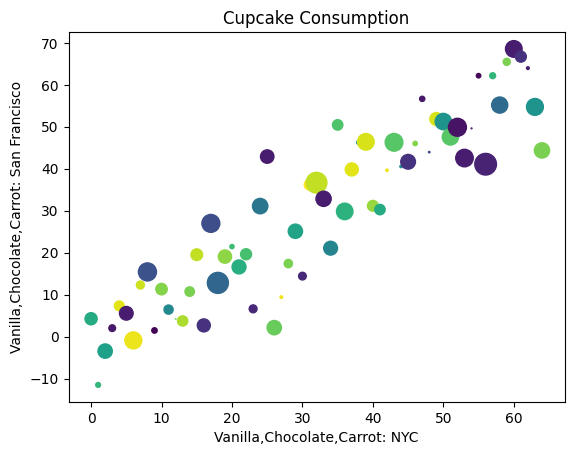

In [0]:
# Create multiple runs with different set of parameters
for params in parameters:
  (run_id, exp_id) = mlflow_run(params)
  print(f"run_id={run_id}") 
  print(f"experiment_id={exp_id}")

### Show the MLflow  UI

* Compare Runs pick two best runs
* Annotate with descriptions and tags